In [1]:
import pandas as pd
cnn_df=pd.read_csv('after_bert1_data_to_compare.csv')

In [2]:
cnn_df.head()

,Email Text,Email Type,BERT Embeddings
0,breathtaking image for your company now workin...,Phishing Email,[ 2.01383844e-01 6.47791803e-01 8.92811060e-...
1,how to substantially increase saleseasily acce...,Phishing Email,[ 3.55392471e-02 6.76252171e-02 4.91976410e-...
2,epac pt e carnoali genie com e carolan genie c...,Phishing Email,[-1.55056268e-03 1.29966527e-01 5.61987758e-...
3,about aptconf there are these lines rpm leave ...,Safe Email,[ 2.52865672e-01 3.50500196e-01 9.46413457e-...
4,cialis soft tabs pre scriptions new clalls sof...,Phishing Email,[-1.62849613e-02 -6.34869561e-02 7.19620764e-...


In [3]:
cnn_df.describe()

,Email Text,Email Type,BERT Embeddings
count,13114,13116,13116
unique,13020,2,12984
top,alink texdecoration noneaactive textdecoration...,Phishing Email,[-7.23443851e-02 1.28986150e-01 4.14267689e-...
freq,6,6558,9


In [4]:
# Check the first few rows of the BERT Embeddings column
print(cnn_df['BERT Embeddings'].head())

# Check the type of the first entry in the BERT Embeddings column
print(type(cnn_df['BERT Embeddings'][0]))


0    [ 2.01383844e-01  6.47791803e-01  8.92811060e-...
1    [ 3.55392471e-02  6.76252171e-02  4.91976410e-...
2    [-1.55056268e-03  1.29966527e-01  5.61987758e-...
3    [ 2.52865672e-01  3.50500196e-01  9.46413457e-...
4    [-1.62849613e-02 -6.34869561e-02  7.19620764e-...
Name: BERT Embeddings, dtype: object
<class 'str'>


In [5]:
def fix_embedding_format(embedding_str):
    # Replace spaces with commas, ensuring proper formatting for lists
    return '[' + ','.join(embedding_str.strip('[]').split()) + ']'

# Apply the formatting fix
cnn_df['BERT Embeddings'] = cnn_df['BERT Embeddings'].apply(fix_embedding_format)


In [6]:
import ast
import numpy as np

# Convert string embeddings to actual NumPy arrays
cnn_df['BERT Embeddings'] = cnn_df['BERT Embeddings'].apply(lambda x: np.array(ast.literal_eval(x)))


In [12]:
print(type(cnn_df['BERT Embeddings'][0]))  # Should output <class 'numpy.ndarray'>
print(cnn_df['BERT Embeddings'][0].shape)  # Should show the shape of the embedding


<class 'numpy.ndarray'>
(768,)


In [13]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.model_selection import train_test_split



# Initialize a list to store the cleaned embeddings
X_cleaned = []

for emb in cnn_df['BERT Embeddings']:
    try:
        # Ensure emb is a valid numpy array
        if isinstance(emb, np.ndarray):
            # Remove 'Ellipsis' from the embedding
            emb = emb[emb != Ellipsis]
            
            # Filter out zero values
            non_zero_emb = emb[emb != 0]
            
            # Only keep embeddings that have at least one non-zero value
            if non_zero_emb.size > 0:
                X_cleaned.append(non_zero_emb)
            else:
                print(f"Skipping embedding with no non-zero values after cleaning: {emb}")
        else:
            print(f"Skipping invalid entry (not numpy array): {emb}")
            continue
    except Exception as e:
        print(f"Skipping invalid entry due to error: {e}")
        continue

# Convert the cleaned list into a numpy array
X_cleaned = np.array(X_cleaned)

# Ensure that we have enough valid data
if X_cleaned.size == 0:
    print(f"Total number of valid embeddings: {len(X_cleaned)}")
    raise ValueError("No valid embeddings found after cleaning. Please check the data.")

# Proceed with the remaining steps as before (e.g., train-test split)
y = cnn_df['Email Type']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = tf.keras.utils.to_categorical(y, num_classes=2)

# Reshape X to make it 3D for CNN input (num_samples, time_steps=1, embedding_dim)
X_cleaned = np.expand_dims(X_cleaned, axis=1)

# Train-Test Split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size=0.2, random_state=42)

# Cast X_train and X_test to float32 to avoid data type issues
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# Check the shapes of the data
print(f"Shape of X_train: {X_train.shape}")  # Should be (num_samples, 1, embedding_dim)
print(f"Shape of y_train: {y_train.shape}")  # Should be (num_samples, 2)


Shape of X_train: (10492, 1, 768)
Shape of y_train: (10492, 2)


In [14]:
print(f"Shape of X_cleaned: {X_cleaned.shape}")

Shape of X_cleaned: (13116, 1, 768)


In [15]:
# Cast X_train and X_test to float32 to avoid data type issues
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)


In [16]:
import numpy as np

def exploration(Sol, lb, ub, dim, nSol, cost_function):
    """
    Exploration phase of the Puma Optimizer.
    
    Parameters:
    - Sol: List of solutions, each having 'X' (position) and 'Cost' (fitness value).
    - lb: Lower bound of the search space (array or scalar).
    - ub: Upper bound of the search space (array or scalar).
    - dim: Dimensionality of the problem.
    - nSol: Number of solutions in the population.
    - cost_function: Function to evaluate the fitness of a solution.

    Returns:
    - Sol: Updated list of solutions after exploration.
    """
    # Sort solutions by cost (ascending)
    Sol = sorted(Sol, key=lambda s: s['Cost'])

    pCR = 0.20  # Exploration crossover probability
    PCR = 1 - pCR  # Complementary probability (Eq. 28)
    p = PCR / nSol  # Incremental step for adjusting probabilities (Eq. 29)

    for i in range(nSol):
        x = Sol[i]['X']  # Current solution's position
        indices = np.random.permutation(nSol)  # Random permutation of indices
        indices = indices[indices != i]  # Remove the current index
        a, b, c, d, e, f = indices[:6]  # Select six distinct indices

        G = 2 * np.random.rand() - 1  # Scaling factor (Eq. 26)

        # Generate candidate solution y
        if np.random.rand() < 0.5:
            y = np.random.rand(dim) * (ub - lb) + lb  # Random position within bounds (Eq. 25)
        else:
            y = (Sol[a]['X'] + G * (Sol[a]['X'] - Sol[b]['X']) +
                 G * (((Sol[a]['X'] - Sol[b]['X']) - (Sol[c]['X'] - Sol[d]['X'])) +
                      ((Sol[c]['X'] - Sol[d]['X']) - (Sol[e]['X'] - Sol[f]['X']))))  # Eq. 25

        # Apply boundary constraints
        y = np.clip(y, lb, ub)

        # Perform crossover to generate new solution z
        z = np.zeros_like(x)
        j0 = np.random.randint(0, len(x))  # Randomly select at least one dimension
        for j in range(len(x)):
            if j == j0 or np.random.rand() <= pCR:
                z[j] = y[j]
            else:
                z[j] = x[j]

        # Evaluate the new solution
        new_sol = {'X': z, 'Cost': cost_function(z)}

        # Update the solution if the new one is better
        if new_sol['Cost'] < Sol[i]['Cost']:
            Sol[i] = new_sol
        else:
            pCR += p  # Adjust probability (Eq. 30)

    return Sol


In [17]:
import numpy as np

def exploitation(Sol, lb, ub, dim, nSol, Best, MaxIter, Iter, cost_function):
    """
    Exploitation phase of the Puma Optimizer.
    
    Parameters:
    - Sol: List of solutions, each having 'X' (position) and 'Cost' (fitness value).
    - lb: Lower bound of the search space (array or scalar).
    - ub: Upper bound of the search space (array or scalar).
    - dim: Dimensionality of the problem.
    - nSol: Number of solutions in the population.
    - Best: Best solution found so far (dictionary with 'X' and 'Cost').
    - MaxIter: Maximum number of iterations.
    - Iter: Current iteration.
    - cost_function: Function to evaluate the fitness of a solution.

    Returns:
    - Sol: Updated list of solutions after exploitation.
    """
    Q = 0.67  # Threshold probability for selecting a strategy
    Beta = 2  # Scaling factor for solution updates

    for i in range(nSol):
        beta1 = 2 * np.random.rand()  # Random scalar
        beta2 = np.random.randn(dim)  # Random normal vector
        w = np.random.randn(dim)  # Eq. 37
        v = np.random.randn(dim)  # Eq. 38
        F1 = np.random.randn(dim) * np.exp(2 - Iter * (2 / MaxIter))  # Eq. 35
        F2 = w * (v ** 2) * np.cos((2 * np.random.rand()) * w)  # Eq. 36

        mbest = np.mean([sol['X'] for sol in Sol], axis=0) / nSol  # Mean best position
        R_1 = 2 * np.random.rand() - 1  # Random scalar (-1 to 1, Eq. 34)
        S1 = (2 * np.random.rand() - 1) + np.random.randn(dim)
        S2 = F1 * R_1 * Sol[i]['X'] + F2 * (1 - R_1) * Best['X']
        VEC = S2 / S1

        # Select exploitation strategy
        if np.random.rand() <= 0.5:
            Xatack = VEC
            if np.random.rand() > Q:
                # Ambush strategy (Eq. 32)
                rand_idx = np.random.randint(0, nSol)
                NewX = Best['X'] + beta1 * np.exp(beta2) * (Sol[rand_idx]['X'] - Sol[i]['X'])
            else:
                # Direct approach (Eq. 32)
                NewX = beta1 * Xatack - Best['X']
        else:
            # Sprint strategy (Eq. 33)
            r1 = np.random.randint(0, nSol)
            NewX = (mbest * Sol[r1]['X'] - ((-1) ** np.random.randint(0, 2)) * Sol[i]['X']) / (1 + (Beta * np.random.rand()))

        # Apply boundary constraints
        NewX = np.clip(NewX, lb, ub)

        # Evaluate the new solution
        new_sol = {'X': NewX, 'Cost': cost_function(NewX)}

        # Update the solution if the new one is better
        if new_sol['Cost'] < Sol[i]['Cost']:
            Sol[i] = new_sol

    return Sol


In [18]:
import numpy as np

def boundary_check(X, lb, ub):
    """
    Ensures the solutions stay within the specified bounds.
    
    Parameters:
    - X: Array of solutions (shape: nSol x dim).
    - lb: Lower bound of the search space (scalar or array).
    - ub: Upper bound of the search space (scalar or array).

    Returns:
    - X: Updated array of solutions with all elements within bounds.
    """
    # Apply boundary constraints
    X = np.clip(X, lb, ub)
    return X


In [19]:
import numpy as np

def puma_core(nSol, MaxIter, lb, ub, dim, cost_function):
    """
    Main Puma Optimizer function.

    Parameters:
    - nSol: Number of solutions (population size).
    - MaxIter: Maximum number of iterations.
    - lb: Lower bound of the search space (array or scalar).
    - ub: Upper bound of the search space (array or scalar).
    - dim: Dimensionality of the problem.
    - cost_function: Function to evaluate the fitness of a solution.

    Returns:
    - best_solution: Position of the best solution found.
    - best_cost: Cost (fitness value) of the best solution.
    - convergence: List of best costs at each iteration.
    """
    # Initialize parameters
    PF = [0.6, 0.4, 0.3]  # Intensification and diversification weights
    Mega_Explor, Mega_Exploit = 0.7, 0.7
    Seq_Time_Explore, Seq_Time_Exploit = np.ones(3), np.ones(3)
    Seq_Cost_Explore, Seq_Cost_Exploit = np.ones(3), np.ones(3)
    F3_Explore, F3_Exploit = 0, 0
    PF_F3 = []

    # Initialize population
    Sol = [{'X': np.random.uniform(lb, ub, dim), 'Cost': cost_function(np.random.uniform(lb, ub, dim))} for _ in range(nSol)]
    Sol = sorted(Sol, key=lambda s: s['Cost'])
    Best = Sol[0]
    Initial_Best = Best
    convergence = []

    # Unexperienced Phase
    for Iter in range(3):
        Sol_Explor = exploration(Sol, lb, ub, dim, nSol, cost_function)  # Run Exploration
        Sol_Exploit = exploitation(Sol, lb, ub, dim, nSol, Best, MaxIter, Iter, cost_function)  # Run Exploitation

        Sol.extend(Sol_Explor + Sol_Exploit)
        Sol = sorted(Sol, key=lambda s: s['Cost'])[:nSol]  # Keep the best nSol solutions
        Best = Sol[0]
        print(f"Best Solution at Iteration {Iter}: {Best}")
        convergence.append(Best['Cost'])

    # Hyper Initialization
    for i in range(3):
        Seq_Cost_Explore[i] = abs(Initial_Best['Cost'] - convergence[i])
        Seq_Cost_Exploit[i] = abs(Initial_Best['Cost'] - convergence[i])

        if Seq_Cost_Explore[i] != 0:
            PF_F3.append(Seq_Cost_Explore[i])
        if Seq_Cost_Exploit[i] != 0:
            PF_F3.append(Seq_Cost_Exploit[i])
        print(f"Best Solution at Iteration {Iter}: {Best}")

    # Calculate Scores
    F1_Explore = PF[0] * (Seq_Cost_Explore[0] / Seq_Time_Explore[0])
    F1_Exploit = PF[0] * (Seq_Cost_Exploit[0] / Seq_Time_Exploit[0])
    F2_Explore = PF[1] * np.sum(Seq_Cost_Explore) / np.sum(Seq_Time_Explore)
    F2_Exploit = PF[1] * np.sum(Seq_Cost_Exploit) / np.sum(Seq_Time_Exploit)
    Score_Explore = F1_Explore + F2_Explore
    Score_Exploit = F1_Exploit + F2_Exploit

    # Experienced Phase
    for Iter in range(4, MaxIter + 1):
        if Score_Explore > Score_Exploit:
            Sol = exploration(Sol, lb, ub, dim, nSol, cost_function)
            F3_Explore += PF[2]
        else:
            Sol = exploitation(Sol, lb, ub, dim, nSol, Best, MaxIter, Iter, cost_function)
            F3_Exploit += PF[2]

        Sol = sorted(Sol, key=lambda s: s['Cost'])[:nSol]
        Best = Sol[0]

        F1_Explore = PF[0] * (Seq_Cost_Explore[0] / Seq_Time_Explore[0])
        F1_Exploit = PF[0] * (Seq_Cost_Exploit[0] / Seq_Time_Exploit[0])
        F2_Explore = PF[1] * np.sum(Seq_Cost_Explore) / np.sum(Seq_Time_Explore)
        F2_Exploit = PF[1] * np.sum(Seq_Cost_Exploit) / np.sum(Seq_Time_Exploit)
        lmn_Explore = 1 - Mega_Explor
        lmn_Exploit = 1 - Mega_Exploit

        Score_Explore = (Mega_Explor * F1_Explore + Mega_Explor * F2_Explore +
                         lmn_Explore * min(PF_F3) * F3_Explore)
        Score_Exploit = (Mega_Exploit * F1_Exploit + Mega_Exploit * F2_Exploit +
                          lmn_Exploit * min(PF_F3) * F3_Exploit)

        convergence.append(Best['Cost'])
        print(f"Best Solution at Iteration {Iter}: {Best}")


    return Best['X'], Best['Cost'], convergence


In [20]:
import numpy as np
from sklearn.feature_selection import mutual_info_classif

# Define Puma Optimizer Function
def puma_optimizer_entry_selection(X_train, y_train, lb, ub, dim, max_iter, pop_size):
    """
    Use Puma Optimizer to select the best entries (rows) from X_train.
    """
    def cost_function(mask):
        """
        Cost function to evaluate the quality of the selected entries.
        :param mask: Binary vector (0/1) indicating selected rows.
        :return: Negative mutual information score (to minimize for PO).
        """
        # Apply the mask to X_train
        selected_indices = np.where(mask.astype(bool))[0]
        
        # Ensure at least one entry is selected
        if len(selected_indices) == 0:
            return float('inf')  # Large penalty for selecting no rows

        # Add penalty for selecting too few rows (e.g., less than 5%)
        min_rows = max(1, int(0.05 * X_train.shape[0]))
        if len(selected_indices) < min_rows:
            penalty = (min_rows - len(selected_indices)) * 100  # Arbitrary large penalty
            return float('inf') + penalty
        
        # Extract selected rows and corresponding labels
        selected_X = X_train[selected_indices]
        selected_y = y_train[selected_indices]
        
        # Calculate Mutual Information with the target variable
        score = mutual_info_classif(selected_X, selected_y, discrete_features=False).mean()
        
        # Return negative score because PO minimizes the cost function
        return -score

    # Initialize PO parameters
    nSol = pop_size
    MaxIter = max_iter

    # Call the core Puma Optimizer (ensure puma_core is defined and working)
    best_position, best_cost, _ = puma_core(nSol, MaxIter, lb, ub, dim, cost_function)

    return best_position

# Prepare the Data
# Assuming X_cleaned and y are already prepared from earlier steps
X_cleaned = np.squeeze(X_cleaned)  # Ensure 2D shape
y = np.argmax(y, axis=1)  # Convert one-hot encoded labels to single-labels

# Validate the data
if X_cleaned.shape[0] == 0 or y.shape[0] == 0:
    raise ValueError("No valid data in X_cleaned or y.")

print(f"Shape of X_cleaned: {X_cleaned.shape}")
print(f"Shape of y: {y.shape}")

# Define bounds and dimensions for PO
num_entries = X_cleaned.shape[0]  # Number of rows in training data
lb = np.zeros(num_entries)  # Lower bound for binary mask (0: row not selected)
ub = np.ones(num_entries)   # Upper bound for binary mask (1: row selected)
dim = num_entries           # Number of rows

# Run PO to select optimal entries
best_mask = puma_optimizer_entry_selection(X_cleaned, y, lb, ub, dim, max_iter=25, pop_size=10)

# Apply the entry mask
selected_indices = np.where(best_mask.astype(bool))[0]

# Validate the mask
if len(selected_indices) == 0:
    raise ValueError("Optimization resulted in no selected rows. Please adjust the cost function.")

X_clean_selected = X_cleaned[selected_indices]
y_clean_selected = y[selected_indices]

# Print selected entries and their count
print(f"Selected Indices: {selected_indices}")
print(f"Number of Selected Entries: {len(selected_indices)}")

# Verify the shapes
print(f"Shape of X_clean_selected: {X_clean_selected.shape}")
print(f"Shape of y_clean_selected: {y_clean_selected.shape}")

# Test data remains unchanged
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X_cleaned: (13116, 768)
Shape of y: (13116,)
Best Solution at Iteration 0: {'X': array([0.13535046, 0.50259022, 0.82966733, ..., 0.57666699, 0.7417592 ,
       0.05452878]), 'Cost': -0.022755467360338132}
Best Solution at Iteration 1: {'X': array([0.13535046, 0.39072991, 0.82966733, ..., 0.57666699, 0.7417592 ,
       0.05452878]), 'Cost': -0.022779838609699645}
Best Solution at Iteration 2: {'X': array([0.79343346, 0.25669554, 0.22072176, ..., 0.6897981 , 0.91441006,
       0.08536265]), 'Cost': -0.022817639439347132}
Best Solution at Iteration 2: {'X': array([0.79343346, 0.25669554, 0.22072176, ..., 0.6897981 , 0.91441006,
       0.08536265]), 'Cost': -0.022817639439347132}
Best Solution at Iteration 2: {'X': array([0.79343346, 0.25669554, 0.22072176, ..., 0.6897981 , 0.91441006,
       0.08536265]), 'Cost': -0.022817639439347132}
Best Solution at Iteration 2: {'X': array([0.79343346, 0.25669554, 0.22072176, ..., 0.6897981 , 0.91441006,
       0.08536265]), 'Cost': -0.022817

In [21]:


# Print the heads of X_clean_selected and y_clean_selected
print("Head of X_clean_selected:")
print(X_clean_selected[:5])  # Show the first 5 rows of X_clean_selected

print("\nHead of y_clean_selected:")
print(y_clean_selected[:5])  # Show the first 5 rows of y_clean_selected

# Print the dimensions of X_clean_selected and y_clean_selected
print(f"\nShape of X_clean_selected: {X_clean_selected.shape}")
print(f"Shape of y_clean_selected: {y_clean_selected.shape}")


Head of X_clean_selected:
[[ 0.20138384  0.6477918   0.89281106 ... -0.61276585 -0.0304683
  -0.46228081]
 [ 0.03553925  0.06762522  0.49197641 ... -0.13539033  0.04412109
   0.05608004]
 [-0.00155056  0.12996653  0.56198776 ... -0.10245717  0.08766595
   0.08612899]
 [ 0.25286567  0.3505002   0.94641346 ... -0.42233488 -0.23579505
  -0.02772782]
 [-0.01628496 -0.06348696  0.71962076 ... -0.13689712 -0.06754023
  -0.03801148]]

Head of y_clean_selected:
[0 0 0 1 0]

Shape of X_clean_selected: (12261, 768)
Shape of y_clean_selected: (12261,)


Shape of X_train: (9808, 768, 1)
Shape of X_test: (2453, 768, 1)
Shape of y_train: (9808, 2)
Shape of y_test: (2453, 2)
Epoch 1/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.8475 - loss: 0.3344 - val_accuracy: 0.9383 - val_loss: 0.1640
Epoch 2/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.9314 - loss: 0.1757 - val_accuracy: 0.9643 - val_loss: 0.1051
Epoch 3/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9418 - loss: 0.1468 - val_accuracy: 0.9669 - val_loss: 0.0896
Epoch 4/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9580 - loss: 0.1186 - val_accuracy: 0.9638 - val_loss: 0.0886
Epoch 5/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9560 - loss: 0.1176 - val_accuracy: 0.9597 - val_loss: 0.1027
Epoch 6/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.9604 - loss: 0.1078 - val_accuracy: 0.9725 - val_loss: 0.0825
Epoch 7/30
246/246 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9679 - loss: 0.0883 - val_accura

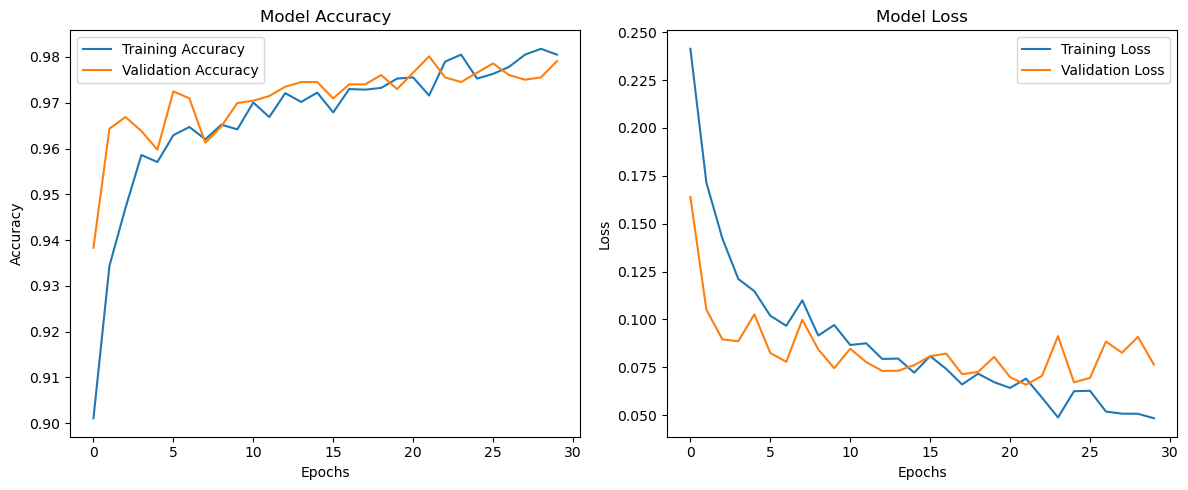

In [22]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, Input
from tensorflow.keras.utils import to_categorical

# Reshape X_clean_selected for Conv1D (samples, time_steps=768, features=1)
X_clean_selected = np.expand_dims(X_clean_selected, axis=-1)

# One-hot encode y_clean_selected
y_clean_selected = to_categorical(y_clean_selected, num_classes=2)

# Split the data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_clean_selected, y_clean_selected, test_size=0.2, random_state=42
)

# Print shapes for debugging
print(f"Shape of X_train: {X_train.shape}")  # Expected: (training_samples, 768, 1)
print(f"Shape of X_test: {X_test.shape}")    # Expected: (test_samples, 768, 1)
print(f"Shape of y_train: {y_train.shape}") # Expected: (training_samples, 2)
print(f"Shape of y_test: {y_test.shape}")   # Expected: (test_samples, 2)

# Build CNN Model
model = Sequential([
    Input(shape=(768, 1)),  # Explicit input layer with updated shape
    Conv1D(filters=64, kernel_size=3, activation='relu'),  # Kernel size 3 for feature learning
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Optional: Save the trained model
# model.save('cnn_model.h5')

# Optional: Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [25]:
 # Evaluate test accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8932 - loss: 0.2870
Test Accuracy: 0.8830
